In [1]:
import sys
import warnings

In [2]:
sys.path.append('/Users/hari/repos/mne-python/')
sys.path.append('/Users/hari/repos/ANLffr/')

In [3]:
import mne
from anlffr.helper import biosemi2mne as bs
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi']  = 120

In [4]:
raw, eves = bs.importbdf('VMA_Pilot_MMN.bdf')

Extracting EDF parameters from /Users/hari/Dropbox/ManuscriptsPosters/AndrewPitch/MMN_Pitch/Data/VMA_Pilot_MMN.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5816319  =      0.000 ...   710.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom EEG reference.
Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
2011 events found
Event IDs: [  1   2   3   4   5   7   8   9  10  11  13  14  15  16  17  19  20  21
  22  23 104 105 106 110 111 112 116 117 118 122 123 124 253]


In [5]:
raw.filter(None, 8)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 13517 samples (1.650 sec)



<RawEDF | VMA_Pilot_MMN.bdf, 41 x 5816320 (710.0 s), ~1.78 GB, data loaded>

In [6]:
from anlffr.preproc import find_blinks
blinks = find_blinks(raw)

Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 180225 samples (22.000 sec)



In [7]:
from mne import compute_proj_epochs
epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                           reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)

Not setting metadata
Not setting metadata
201 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [8]:
blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=1)

No gradiometers found. Forcing n_grad to 0
No magnetometers found. Forcing n_mag to 0
Adding projection: eeg-998--0.250-0.250-PCA-01


In [9]:
raw.add_proj(blink_proj)

1 projection items deactivated


<RawEDF | VMA_Pilot_MMN.bdf, 41 x 5816320 (710.0 s), ~1.78 GB, data loaded>

In [10]:
epochs_deviant = mne.Epochs(raw, eves, event_id=[1, 7, 13, 19], baseline=(-0.2, 0.), proj=True,
                    tmin=-0.2, tmax=1.0, reject=dict(eeg=80e-6))

Not setting metadata
Not setting metadata
402 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [11]:
epochs_standard = mne.Epochs(raw, eves, event_id=[104, 105, 106, 110, 111, 112, 116, 117, 118, 122, 123, 124], baseline=(-0.2, 0.), proj=True,
                    tmin=-0.2, tmax=1.0, reject=dict(eeg=80e-6))

Not setting metadata
Not setting metadata
402 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [12]:
erp_standard = epochs_standard.average()

    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['A28']


In [13]:
erp_deviant = epochs_deviant.average()

    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['A28']
    Rejecting  epoch based on EEG : ['A28']


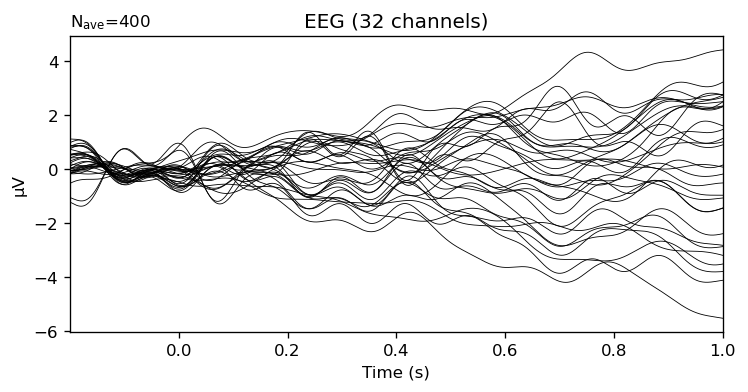

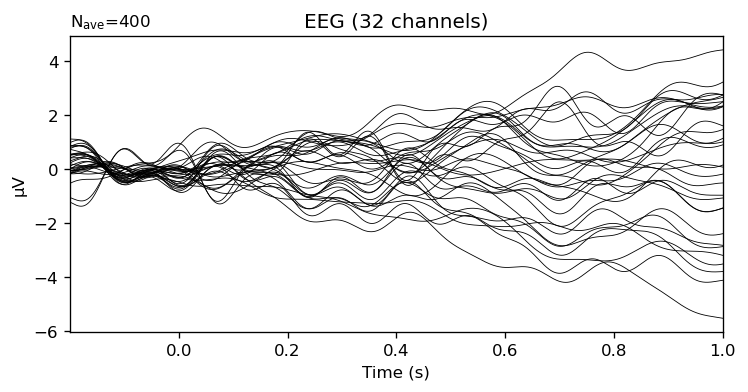

In [14]:
erp_standard.plot()

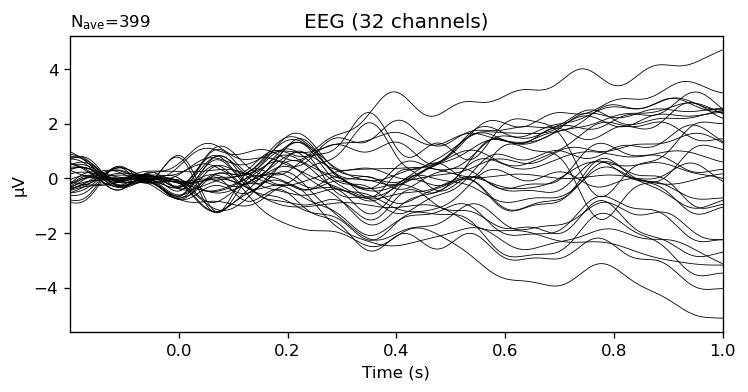

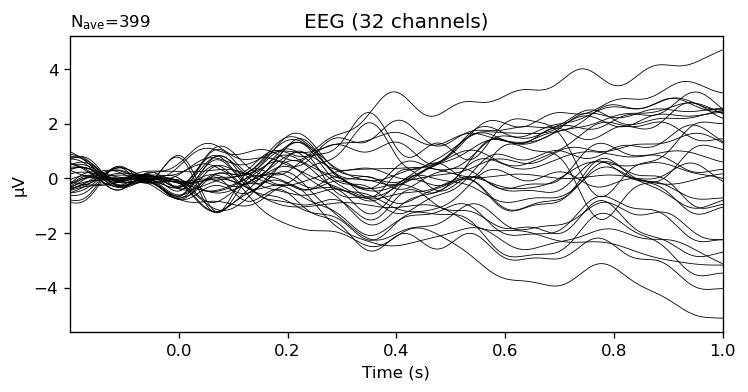

In [15]:
erp_deviant.plot()

In [16]:
Fz_std = erp_standard.data[30, :]
Fz_dev = erp_deviant.data[30, :]
t = erp_deviant.times

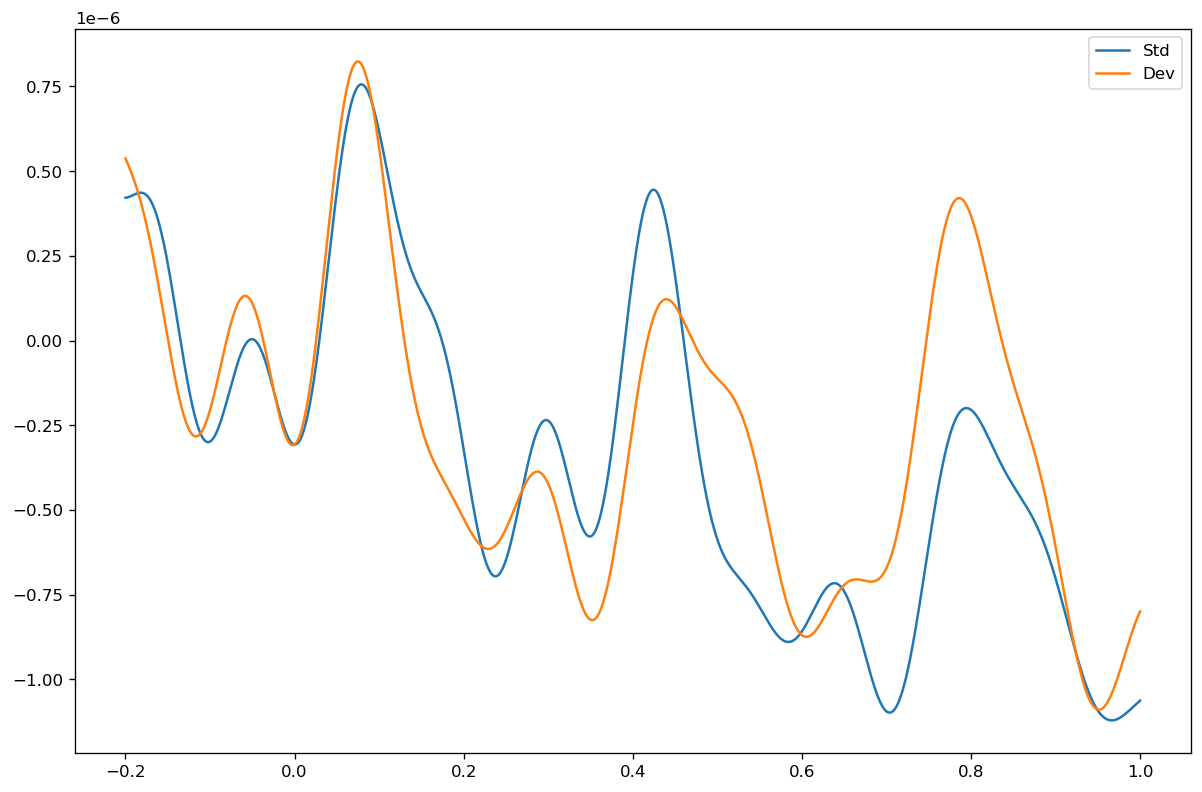

In [17]:
plt.plot(t, Fz_std)
plt.plot(t, Fz_dev)
plt.legend(('Std', 'Dev'))

(-0.1, 0.4)

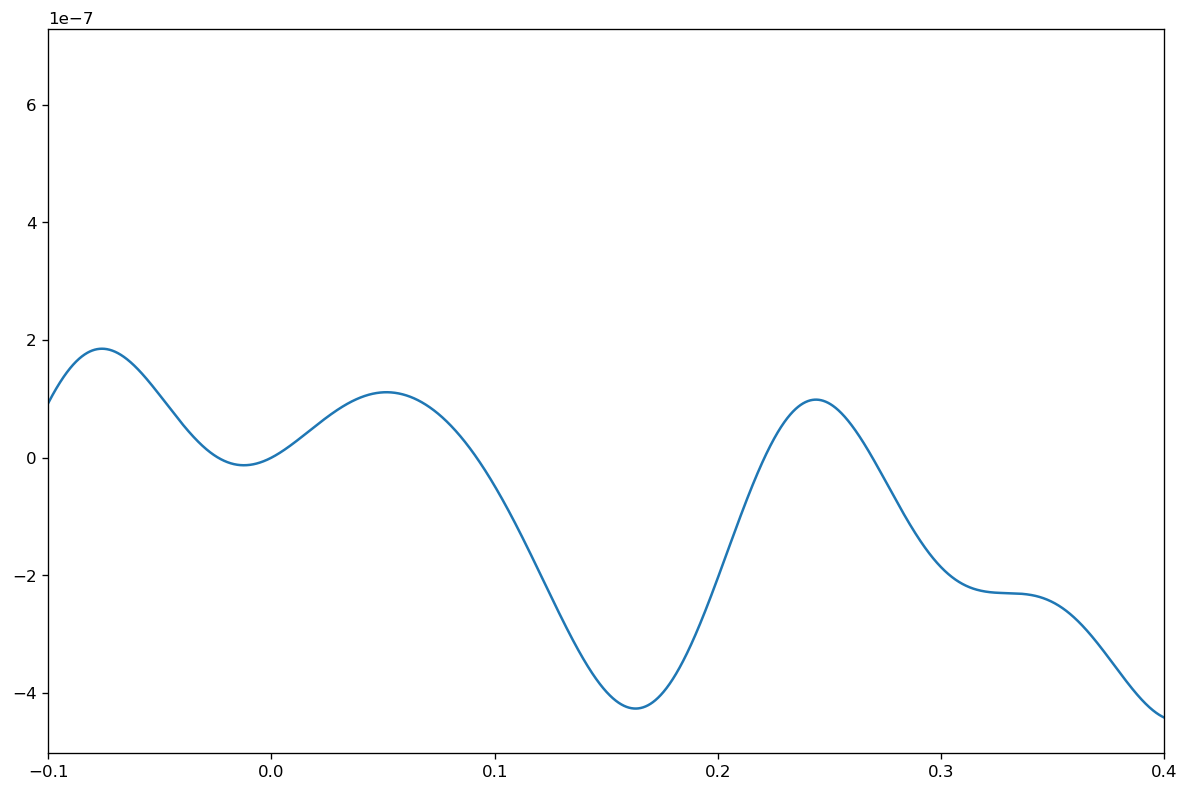

In [18]:
MMN = Fz_dev - Fz_std
plt.plot(t, MMN)
plt.xlim((-0.1, 0.4))

In [19]:
import numpy as np

In [20]:
eves

array([[   7770,       0,     253],
       [  33172,       0,       7],
       [  35866,       0,       2],
       ...,
       [5785257,       0,      21],
       [5787999,       0,      22],
       [5790898,       0,     123]])

In [21]:
eves2 = np.empty((0, 3), dtype=np.int32)
eves3 = np.empty((0, 3), dtype=np.int32)
for k in range(eves.shape[0]):
    if (eves[k, 2] > 100) and (np.mod(eves[k, 2] - 100, 6) == 0):
        eves2 = np.concatenate((eves2, eves[k+1, :][None, :]), axis=0)
        eves3 = np.concatenate((eves3, eves[k, :][None, :]), axis=0)


In [22]:
eves3.shape

(134, 3)

In [23]:
eves2.shape

(134, 3)

In [24]:
epochs_std6 = mne.Epochs(raw, eves3, event_id=[106, 112, 118, 124], baseline=(-0.2, 0.), proj=True,
                    tmin=-0.2, tmax=1.0, reject=dict(eeg=80e-6))

Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [25]:
epochs_dev6 = mne.Epochs(raw, eves2, event_id=[1, 7, 13, 19], baseline=(-0.2, 0.), proj=True,
                    tmin=-0.2, tmax=1.0, reject=dict(eeg=80e-6))

Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated


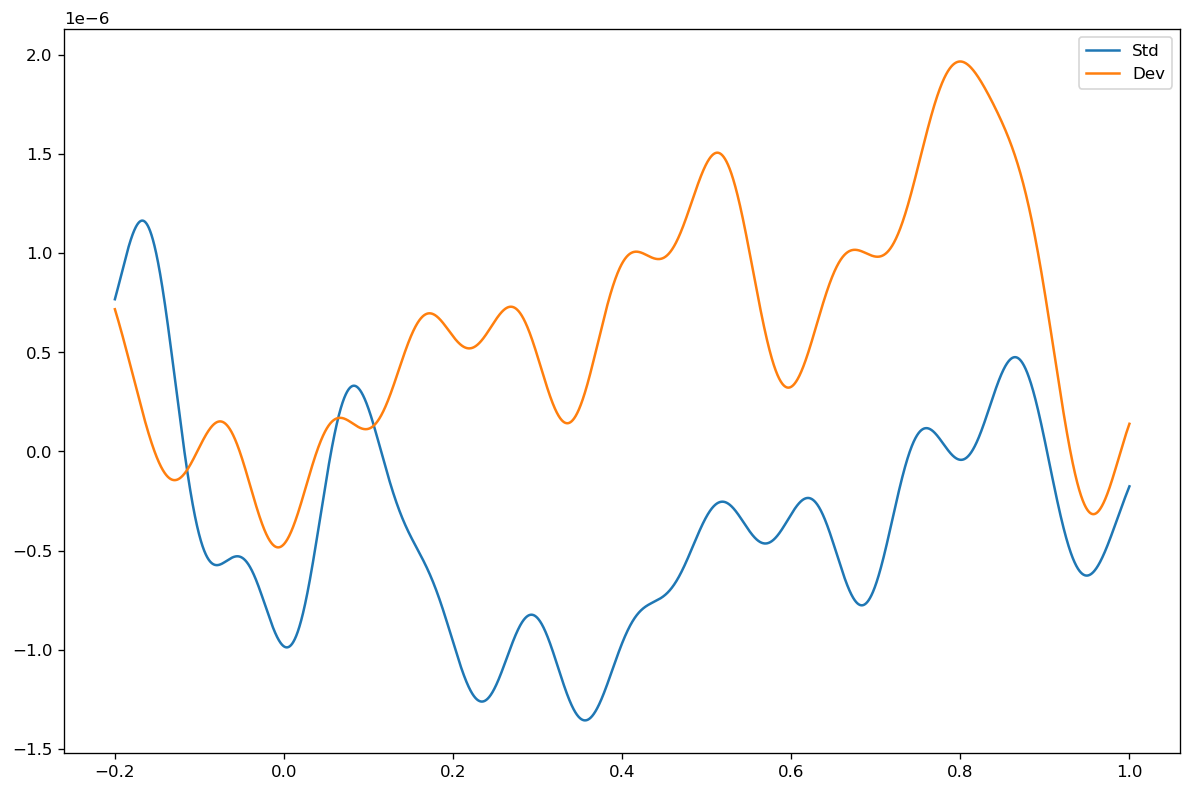

In [32]:
ch = 31
ch_std6 = epochs_std6.average().data[ch, :]
ch_dev6 = epochs_dev6.average().data[ch, :]
plt.plot(t, ch_std6)
plt.plot(t, ch_dev6)
plt.legend(('Std', 'Dev'))